## Transaction Data로부터 파생변수(Feature) 만들기
- input : transactions.csv (트랜잭션 형식의 판매 데이터)
- output : features.csv (머신러닝 모델링이 가능한 형태의 고객 feature 데이터, 일명 Customer Signature)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import matplotlib
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

font_manager.get_fontconfig_fonts()
font_location = "c:/windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

In [2]:
data = pd.read_csv('./data/transactions.csv', encoding='cp949')
data.head()

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000
1,0,2007-03-30 00:00:00,강남점,342220,니 트,시티웨어,480000
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정,기타,20000


In [3]:
# 파생변수를 저장할 빈 리스트
features = []

### Numeric Features

**[파생변수 1-4]** 총구매액, 구매건수, 평균구매액, 최대구매액

In [4]:
f = data.groupby('cust_id')['amount'].agg([
    ('총구매액', np.sum), 
    ('구매건수', np.size), 
    ('평균구매액', lambda x: np.round(np.mean(x))),
    ('최대구매액', np.max),
]).reset_index()
features.append(f); f

,cust_id,총구매액,구매건수,평균구매액,최대구매액
0,0,68282840,74,922741.0,11264000
1,1,2136000,3,712000.0,2136000
2,2,3197000,4,799250.0,1639000
3,3,16077620,44,365400.0,4935000
4,4,29050000,3,9683333.0,24000000
...,...,...,...,...,...
3495,3495,3175200,2,1587600.0,3042900
3496,3496,29628600,13,2279123.0,7200000
3497,3497,75000,1,75000.0,75000
3498,3498,1875000,2,937500.0,1000000


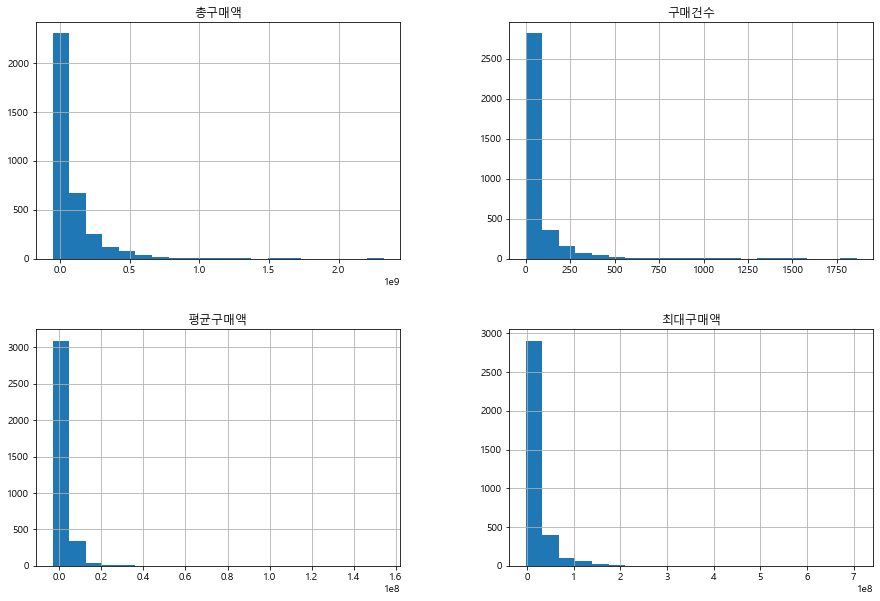

In [5]:
f.drop('cust_id', axis=1).hist(bins=20, figsize=(15,10))
plt.show()

**[파생변수 5-7]** 구매상품종류(goods_id, gds_grp_nm, gds_grp_mclas_nm 각각)

In [6]:
f = data.groupby('cust_id').agg({
    'goods_id': [('구매상품종류1', lambda x: x.nunique())],
    'gds_grp_nm': [('구매상품종류2', lambda x: x.nunique())],
    'gds_grp_mclas_nm': [('구매상품종류3', lambda x: x.nunique())]
})

print('before drop level:', f.columns)
f.columns = f.columns.droplevel()  
# 동일한 코드: f.columns = [j for _, j in f.columns]
f = f.reset_index()
features.append(f); f

before drop level: MultiIndex([(        'goods_id', '구매상품종류1'),
            (      'gds_grp_nm', '구매상품종류2'),
            ('gds_grp_mclas_nm', '구매상품종류3')],
           )


,cust_id,구매상품종류1,구매상품종류2,구매상품종류3
0,0,35,28,17
1,1,2,2,2
2,2,1,2,2
3,3,24,20,13
4,4,2,3,3
...,...,...,...,...
3495,3495,1,2,2
3496,3496,9,7,5
3497,3497,1,1,1
3498,3498,1,1,1


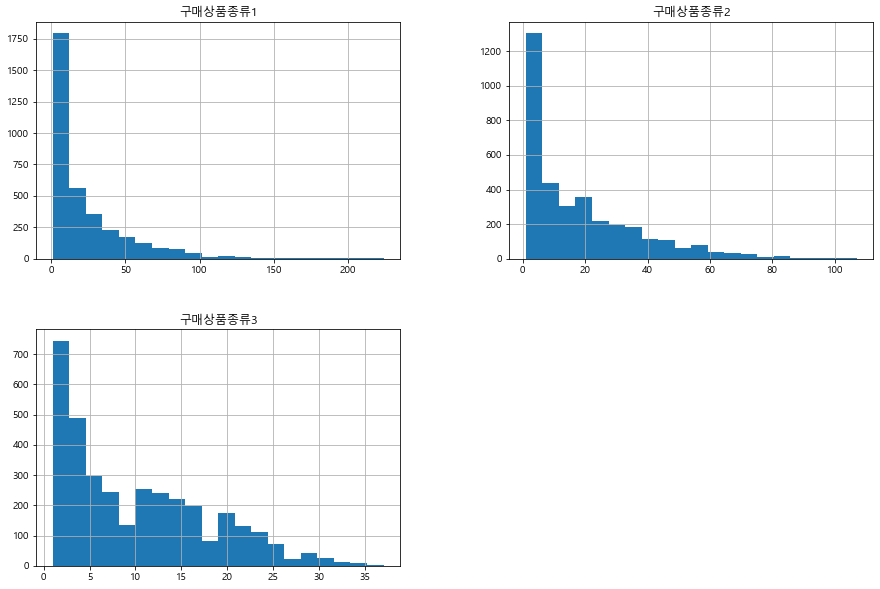

In [7]:
f.drop('cust_id', axis=1).hist(bins=20, figsize=(15,10))
plt.show()

**[파생변수 8-14]** 내점일수, 구매주기, 주말방문비율, 계절별 구매비율(Spring(3-5)/Summer(6-8)/Fall(9-11)/Winter(12-2))

In [8]:
f = data.groupby('cust_id')['tran_date'].agg([
    ('내점일수',lambda x: x.str[:10].nunique()),
    ('구매주기', lambda x: int((x.astype('datetime64').max() - x.astype('datetime64').min()).days / x.str[:10].nunique())),
    ('주말방문비율', lambda x: np.mean(pd.to_datetime(x).dt.dayofweek>4)),
    ('봄-구매비율', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([3,4,5]))),
    ('여름-구매비율', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([6,7,8]))),
    ('가을-구매비율', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([9,10,11]))),
    ('겨울-구매비율', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([1,2,12])))
]).reset_index()
# 구매주기는 가장 최근 방문한 날짜에서, 가장 오래 전 방문한 날짜를 뺀 뒤 내점일수로 나눠준 것
features.append(f); f

,cust_id,내점일수,구매주기,주말방문비율,봄-구매비율,여름-구매비율,가을-구매비율,겨울-구매비율
0,0,19,17,0.527027,0.094595,0.391892,0.378378,0.135135
1,1,2,1,0.000000,0.000000,0.000000,1.000000,0.000000
2,2,2,1,0.000000,0.000000,0.000000,0.000000,1.000000
3,3,18,16,0.318182,0.590909,0.159091,0.113636,0.136364
4,4,2,85,0.000000,0.333333,0.000000,0.666667,0.000000
...,...,...,...,...,...,...,...,...
3495,3495,1,0,1.000000,0.000000,1.000000,0.000000,0.000000
3496,3496,8,40,0.461538,0.076923,0.076923,0.461538,0.384615
3497,3497,1,0,0.000000,0.000000,0.000000,0.000000,1.000000
3498,3498,2,39,0.000000,0.500000,0.000000,0.000000,0.500000


**[파생변수 15-16]** 환불금액, 환불건수

In [9]:
f = data[data.amount < 0].groupby('cust_id')['amount'].agg([
    ('환불금액', lambda x: x.sum() * -1),
    ('환불건수', np.size)
]).reset_index()
features.append(f); f

,cust_id,환불금액,환불건수
0,0,6860000,3
1,1,300000,1
2,5,462000,1
3,6,4582000,3
4,7,29524000,4
...,...,...,...
1200,3488,529602320,13
1201,3489,3840000,1
1202,3493,9767000,2
1203,3496,6049600,1


**[파생변수 17-18]** 내점 당 구매액, 구매건수

In [10]:
# 내점 당 구매액 = 총구매액 / 내점일수
visits = data.groupby('cust_id')['tran_date'].agg(lambda x: x.nunique())
f = (data.groupby('cust_id')['amount'].sum() / visits).reset_index().rename(columns={0 : "내점당구매액"})
features.append(f); display(f)

f = (data.groupby('cust_id')['amount'].size() / visits).reset_index().rename(columns={0 : "내점당구매건수"})
features.append(f); f

,cust_id,내점당구매액
0,0,3.593834e+06
1,1,1.068000e+06
2,2,1.598500e+06
3,3,8.932011e+05
4,4,1.452500e+07
...,...,...
3495,3495,3.175200e+06
3496,3496,3.703575e+06
3497,3497,7.500000e+04
3498,3498,9.375000e+05


,cust_id,내점당구매건수
0,0,3.894737
1,1,1.500000
2,2,2.000000
3,3,2.444444
4,4,1.500000
...,...,...
3495,3495,2.000000
3496,3496,1.625000
3497,3497,1.000000
3498,3498,1.000000


**[파생변수 19-24]** 최근 3개월, 6개월, 12개월 구매금액 및 구매건수

In [11]:
# pd.to_datetime(), pd.offsets.MonthBegin(3)
for m in [3,6,12]:
    start = str(pd.to_datetime(data.tran_date.max()) - pd.offsets.MonthBegin(m))
    f = data.query('tran_date >= @start').groupby('cust_id')['amount'].agg([
        (f'최근{m}개월_구매금액', np.sum), 
        (f'최근{m}개월_구매건수', np.size)
    ]).reset_index()
    display(f)
    features.append(f)

,cust_id,최근3개월_구매금액,최근3개월_구매건수
0,0,29084140,27
1,1,2136000,3
2,3,549620,4
3,4,27000000,2
4,7,140818200,36
...,...,...,...
2439,3492,9154000,1
2440,3493,42697460,101
2441,3494,82800000,2
2442,3496,12028000,7


,cust_id,최근6개월_구매금액,최근6개월_구매건수
0,0,42601240,61
1,1,2136000,3
2,3,1284060,11
3,4,27000000,2
4,6,2250000,2
...,...,...,...
2778,3492,9154000,1
2779,3493,59972640,140
2780,3494,82800000,2
2781,3496,19224000,11


,cust_id,최근12개월_구매금액,최근12개월_구매건수
0,0,68282840,74
1,1,2136000,3
2,2,3197000,4
3,3,16077620,44
4,4,29050000,3
...,...,...,...
3495,3495,3175200,2
3496,3496,29628600,13
3497,3497,75000,1
3498,3498,1875000,2


**[파생변수 25]** 구매추세 패턴

In [12]:
#구매추세 패턴 정의 : 시간의 흐름에 따른 구매액의 변화를 구매추세로서 정의하겠습니다. cust_id 별 추세선을 Numeric Feature 로서 하나의 column 안에 표현할 순 없기 때문에 이전 달 구매금액과 비교를 통해 구매추세를 파악했습니다.
#시간의 흐름은 월 단위로 기록했고, 최종적으로 양수가 나왔다면 구매 금액의 증가 추세, 음수라면 감소 추세로 파악했습니다.
month_trend = []
for i in range(len(data)) :
    if pd.to_datetime(data['tran_date'][i]).month == 1 :
        month_trend.append(1)
    elif pd.to_datetime(data['tran_date'][i]).month == 2 :
        month_trend.append(2)
    elif pd.to_datetime(data['tran_date'][i]).month == 3 :
        month_trend.append(3)
    elif pd.to_datetime(data['tran_date'][i]).month == 4 :
        month_trend.append(4)
    elif pd.to_datetime(data['tran_date'][i]).month == 5 :
        month_trend.append(5)
    elif pd.to_datetime(data['tran_date'][i]).month == 6 :
        month_trend.append(6)
    elif pd.to_datetime(data['tran_date'][i]).month == 7 :
        month_trend.append(7)
    elif pd.to_datetime(data['tran_date'][i]).month == 8 :
        month_trend.append(8)
    elif pd.to_datetime(data['tran_date'][i]).month == 9 :
        month_trend.append(9)
    elif pd.to_datetime(data['tran_date'][i]).month == 10 :
        month_trend.append(10)
    elif pd.to_datetime(data['tran_date'][i]).month == 11 :
        month_trend.append(11)
    elif pd.to_datetime(data['tran_date'][i]).month == 12 :
        month_trend.append(12)

data['월'] = month_trend
f = data.groupby(['cust_id','월'])['amount'].sum().reset_index()
f = f.sort_values(['cust_id','월'])
month_trend_dif = []

for i in range(len(f)-1) :
    if f['cust_id'][i+1] == f['cust_id'][i] :
        month_trend_dif.append(f['amount'][i+1]-f['amount'][i])
    else :
        month_trend_dif.append(0)
month_trend_dif.append(0)
f['월별차액'] = month_trend_dif
f = f.groupby('cust_id')['월별차액'].sum().reset_index()
features.append(f)

**[파생변수 26]** 가격 선호도

In [13]:
#가격 선호도의 정의 : 제품 구매 건수를 가격대별로 나눠 빈도수를 파악, 10,000원,100,000원,300,000원,500,000원,1,000,000원 단위로 구간을 정한 뒤 각 구간에 대한 구매 빈도수를 구합니다.
#고객 별로 가장 많은 빈도 수로 구매한 구간이 그 고객이 선호하는 가격 구간으로 파악됩니다. 환불 행위에 대해서는 한 번 구매를 했다면, 그 가격에 대한 선호를 표현한 것으로 여기고 제외하지 않았습니다.
price_level = []
for i in range(len(data)) :
    if data['amount'][i] < 10000 :
        price_level.append('1000')
    elif 10000 <= data['amount'][i] < 100000 :
        price_level.append('10000')
    elif 100000 <= data['amount'][i] < 300000 :
        price_level.append('100000')
    elif 300000 <= data['amount'][i] < 500000 :
        price_level.append('300000')
    elif 500000 <= data['amount'][i] < 1000000 :
        price_level.append('500000')
    else :
        price_level.append('1000000')
data['가격 선호도'] = price_level
f = data.groupby(['cust_id','가격 선호도'])['amount'].count().reset_index()
f = f.sort_values(by = ['amount'], ascending = False).drop_duplicates(['cust_id'], keep = 'first')
f = f.sort_values('cust_id')
f = f[['cust_id','가격 선호도']]
features.append(f)

**[파생변수 27]** 시즌 선호도

In [14]:
# 시즌 선호도의 정의 : 계절별 구매비율은 위에서 이미 구해져있기 때문에, 시즌을 계절이 아닌 방학 기간과 학기 기간을 시즌으로 정의했습니다.
# 특정 기간인 시즌마다의 구매 비율을 구해 0.5 이상의 비율을 가진 시즌이 선호하는 시즌이 됩니다. 그런 시즌이 없다면 선호하는 시즌이 없는 고객으로 간주됩니다.
# 0 은 선호 시즌 없음, 1은 1학기 선호, 2는 2학기 선호, 3은 여름방학 선호, 4는 겨울방학 선호
f = data.groupby('cust_id')['tran_date'].agg([
    ('1학기-구매비율', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([3,4,5,6]))),
    ('2학기-구매비율', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([9,10,11,12]))),
    ('여름방학-구매비율', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([7,8]))),
    ('겨울방학-구매비율', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([1,2])))
]).reset_index()

season_level = []
for i in range(len(f)):
    if f['1학기-구매비율'][i] >= 0.5 :
        season_level.append(1)
    elif f['2학기-구매비율'][i] >= 0.5 :
        season_level.append(2)
    elif f['여름방학-구매비율'][i] >= 0.5 :
        season_level.append(3)
    elif f['겨울방학-구매비율'][i] >= 0.5 :
        season_level.append(4)
    else :
        season_level.append(0)
f['시즌 선호도'] = season_level
f = f[['cust_id','시즌 선호도']]
features.append(f)

**[파생변수 28]** 휴면(또는 이탈) 여부

In [15]:
#휴면(또는 이탈) 여부에 대한 정의 : 휴면 여부를 판단하기 위해선 시간에 대한 비교가 필요한데, 현재 시점에 대한 정보가 없으므로 현 시점을 2008.01.01 로 정의하겠습니다.
#현 시점을 기준으로, 3개월 간 구매기록이 없는 고객은 휴면(또는 이탈) 고객으로 판단합니다.
time = [] 
for i in range(len(data)):
    time.append(pd.to_datetime(data['tran_date'][i]))

is_quit = []
for i in range(len(time)):
    if time[i].month <=9 :
        is_quit.append(1)
    else :
        is_quit.append(0)
data['휴면여부'] = is_quit
f = data.drop_duplicates(['cust_id'],keep = 'last').sort_values(by = ['cust_id'], axis = 0)[['cust_id','휴면여부']]
features.append(f)

**[파생변수 29-58]** Top-10 베스트 셀러(gds_grp_mclas_nm)에 대한 구매 금액/건수/여부

In [16]:
# 고객 별 구매 건수를 기준으로 Top-10 베스트 셀러를 선정합니다.
data.groupby('gds_grp_mclas_nm').count()['cust_id'].reset_index().sort_values('cust_id', ascending = False)[0:11]
# 분류에 대한 정의가 없는 기타를 제외한 top 10 = 농산물, 가공식품, 축산가공, 수산품, 화장품, 디자이너, 시티웨어, 일용잡화, 육류, 차/커피
# Top-10 에 대한 구매 여부

is_top_1 = []
for i in range(len(data)) :
    if data['gds_grp_mclas_nm'][i] == '농산물':
        is_top_1.append(1)
    else :
        is_top_1.append(0)
data['농산물_구매여부'] = is_top_1
f = data[['cust_id','농산물_구매여부']]
f = f.sort_values(by = ['cust_id'], ascending = True)
f = f.groupby('cust_id')['농산물_구매여부'].sum().reset_index()
o_x = []
for i in range(len(f)):
    if f['농산물_구매여부'][i]>0 :
        o_x.append(1)
    else :
        o_x.append(0)
f['농산물_구매여부'] = o_x
features.append(f)

is_top_2 = []
for i in range(len(data)) :
    if data['gds_grp_mclas_nm'][i] == '가공식품':
        is_top_2.append(1)
    else :
        is_top_2.append(0)
data['가공식품_구매여부'] = is_top_2
f = data[['cust_id','가공식품_구매여부']]
f = f.sort_values(by = ['cust_id'], ascending = True)
f = f.groupby('cust_id')['가공식품_구매여부'].sum().reset_index()
o_x_2 = []
for i in range(len(f)):
    if f['가공식품_구매여부'][i]>0 :
        o_x_2.append(1)
    else :
        o_x_2.append(0)
f['가공식품_구매여부'] = o_x_2
features.append(f)

is_top_3 = []
for i in range(len(data)) :
    if data['gds_grp_mclas_nm'][i] == '축산가공':
        is_top_3.append(1)
    else :
        is_top_3.append(0)
data['축산가공_구매여부'] = is_top_3
f = data[['cust_id','축산가공_구매여부']]
f = f.sort_values(by = ['cust_id'], ascending = True)
f = f.groupby('cust_id')['축산가공_구매여부'].sum().reset_index()
o_x_3 = []
for i in range(len(f)):
    if f['축산가공_구매여부'][i]>0 :
        o_x_3.append(1)
    else :
        o_x_3.append(0)
f['축산가공_구매여부'] = o_x_3
features.append(f)

is_top_4 = []
for i in range(len(data)) :
    if data['gds_grp_mclas_nm'][i] == '수산품':
        is_top_4.append(1)
    else :
        is_top_4.append(0)
data['수산품_구매여부'] = is_top_4
f = data[['cust_id','수산품_구매여부']]
f = f.sort_values(by = ['cust_id'], ascending = True)
f = f.groupby('cust_id')['수산품_구매여부'].sum().reset_index()
o_x_4 = []
for i in range(len(f)):
    if f['수산품_구매여부'][i]>0 :
        o_x_4.append(1)
    else :
        o_x_4.append(0)
f['수산품_구매여부'] = o_x_4
features.append(f)

is_top_5 = []
for i in range(len(data)) :
    if data['gds_grp_mclas_nm'][i] == '화장품':
        is_top_5.append(1)
    else :
        is_top_5.append(0)
data['화장품_구매여부'] = is_top_5
f = data[['cust_id','화장품_구매여부']]
f = f.sort_values(by = ['cust_id'], ascending = True)
f = f.groupby('cust_id')['화장품_구매여부'].sum().reset_index()
o_x_5 = []
for i in range(len(f)):
    if f['화장품_구매여부'][i]>0 :
        o_x_5.append(1)
    else :
        o_x_5.append(0)
f['화장품_구매여부'] = o_x_5
features.append(f)

is_top_6 = []
for i in range(len(data)) :
    if data['gds_grp_mclas_nm'][i] == '디자이너':
        is_top_6.append(1)
    else :
        is_top_6.append(0)
data['디자이너_구매여부'] = is_top_6
f = data[['cust_id','디자이너_구매여부']]
f = f.sort_values(by = ['cust_id'], ascending = True)
f = f.groupby('cust_id')['디자이너_구매여부'].sum().reset_index()
o_x_6 = []
for i in range(len(f)):
    if f['디자이너_구매여부'][i]>0 :
        o_x_6.append(1)
    else :
        o_x_6.append(0)
f['디자이너_구매여부'] = o_x_6
features.append(f)

is_top_7 = []
for i in range(len(data)) :
    if data['gds_grp_mclas_nm'][i] == '시티웨어':
        is_top_7.append(1)
    else :
        is_top_7.append(0)
data['시티웨어_구매여부'] = is_top_7
f = data[['cust_id','시티웨어_구매여부']]
f = f.sort_values(by = ['cust_id'], ascending = True)
f = f.groupby('cust_id')['시티웨어_구매여부'].sum().reset_index()
o_x_7 = []
for i in range(len(f)):
    if f['시티웨어_구매여부'][i]>0 :
        o_x_7.append(1)
    else :
        o_x_7.append(0)
f['시티웨어_구매여부'] = o_x_7
features.append(f)

is_top_8 = []
for i in range(len(data)) :
    if data['gds_grp_mclas_nm'][i] == '일용잡화':
        is_top_8.append(1)
    else :
        is_top_8.append(0)
data['일용잡화_구매여부'] = is_top_8
f = data[['cust_id','일용잡화_구매여부']]
f = f.sort_values(by = ['cust_id'], ascending = True)
f = f.groupby('cust_id')['일용잡화_구매여부'].sum().reset_index()
o_x_8 = []
for i in range(len(f)):
    if f['일용잡화_구매여부'][i]>0 :
        o_x_8.append(1)
    else :
        o_x_8.append(0)
f['일용잡화_구매여부'] = o_x_8
features.append(f)

is_top_9 = []
for i in range(len(data)) :
    if data['gds_grp_mclas_nm'][i] == '육류':
        is_top_9.append(1)
    else :
        is_top_9.append(0)
data['육류_구매여부'] = is_top_9
f = data[['cust_id','육류_구매여부']]
f = f.sort_values(by = ['cust_id'], ascending = True)
f = f.groupby('cust_id')['육류_구매여부'].sum().reset_index()
o_x_9 = []
for i in range(len(f)):
    if f['육류_구매여부'][i]>0 :
        o_x_9.append(1)
    else :
        o_x_9.append(0)
f['육류_구매여부'] = o_x_9
features.append(f)

is_top_10 = []
for i in range(len(data)) :
    if data['gds_grp_mclas_nm'][i] == '차/커피':
        is_top_10.append(1)
    else :
        is_top_10.append(0)
data['차/커피_구매여부'] = is_top_10
f = data[['cust_id','차/커피_구매여부']]
f = f.sort_values(by = ['cust_id'], ascending = True)
f = f.groupby('cust_id')['차/커피_구매여부'].sum().reset_index()
o_x_10 = []
for i in range(len(f)):
    if f['차/커피_구매여부'][i]>0 :
        o_x_10.append(1)
    else :
        o_x_10.append(0)
f['차/커피_구매여부'] = o_x_10
features.append(f)

In [17]:
# Top-10에 대한 구매 금액
sum_top_1 = []
for i in range(len(data)) :
    if data['gds_grp_mclas_nm'][i] == '농산물':
        sum_top_1.append(data['amount'][i])
    else :
        sum_top_1.append(0)
data['농산물 구매 금액'] = sum_top_1        
f = data.groupby('cust_id')['농산물 구매 금액'].sum().reset_index()
features.append(f)

sum_top_2 = []
for i in range(len(data)) :
    if data['gds_grp_mclas_nm'][i] == '가공식품':
        sum_top_2.append(data['amount'][i])
    else :
        sum_top_2.append(0)
data['가공식품 구매 금액'] = sum_top_2        
f = data.groupby('cust_id')['가공식품 구매 금액'].sum().reset_index()
features.append(f)

sum_top_3 = []
for i in range(len(data)) :
    if data['gds_grp_mclas_nm'][i] == '축산가공':
        sum_top_3.append(data['amount'][i])
    else :
        sum_top_3.append(0)
data['축산가공 구매 금액'] = sum_top_3        
f = data.groupby('cust_id')['축산가공 구매 금액'].sum().reset_index()
features.append(f)

sum_top_4 = []
for i in range(len(data)) :
    if data['gds_grp_mclas_nm'][i] == '수산품':
        sum_top_4.append(data['amount'][i])
    else :
        sum_top_4.append(0)
data['수산품 구매 금액'] = sum_top_4        
f = data.groupby('cust_id')['수산품 구매 금액'].sum().reset_index()
features.append(f)

sum_top_5 = []
for i in range(len(data)) :
    if data['gds_grp_mclas_nm'][i] == '화장품':
        sum_top_5.append(data['amount'][i])
    else :
        sum_top_5.append(0)
data['화장품 구매 금액'] = sum_top_5        
f = data.groupby('cust_id')['화장품 구매 금액'].sum().reset_index()
features.append(f)

sum_top_6 = []
for i in range(len(data)) :
    if data['gds_grp_mclas_nm'][i] == '디자이너':
        sum_top_6.append(data['amount'][i])
    else :
        sum_top_6.append(0)
data['디자이너 구매 금액'] = sum_top_6        
f = data.groupby('cust_id')['디자이너 구매 금액'].sum().reset_index()
features.append(f)

sum_top_7 = []
for i in range(len(data)) :
    if data['gds_grp_mclas_nm'][i] == '시티웨어':
        sum_top_7.append(data['amount'][i])
    else :
        sum_top_7.append(0)
data['시티웨어 구매 금액'] = sum_top_7        
f = data.groupby('cust_id')['시티웨어 구매 금액'].sum().reset_index()
features.append(f)

sum_top_8 = []
for i in range(len(data)) :
    if data['gds_grp_mclas_nm'][i] == '일용잡화':
        sum_top_8.append(data['amount'][i])
    else :
        sum_top_8.append(0)
data['일용잡화 구매 금액'] = sum_top_8        
f = data.groupby('cust_id')['일용잡화 구매 금액'].sum().reset_index()
features.append(f)

sum_top_9 = []
for i in range(len(data)) :
    if data['gds_grp_mclas_nm'][i] == '육류':
        sum_top_9.append(data['amount'][i])
    else :
        sum_top_9.append(0)
data['육류 구매 금액'] = sum_top_9        
f = data.groupby('cust_id')['육류 구매 금액'].sum().reset_index()
features.append(f)

sum_top_10 = []
for i in range(len(data)) :
    if data['gds_grp_mclas_nm'][i] == '차/커피':
        sum_top_10.append(data['amount'][i])
    else :
        sum_top_10.append(0)
data['차/커피 구매 금액'] = sum_top_10        
f = data.groupby('cust_id')['차/커피 구매 금액'].sum().reset_index()
features.append(f)

In [18]:
# Top-10에 대한 구매건수
data['농산물 구매건수'] = is_top_1
f = data.groupby('cust_id')['농산물 구매건수'].sum().reset_index()
features.append(f)

data['가공식품 구매건수'] = is_top_2
f = data.groupby('cust_id')['가공식품 구매건수'].sum().reset_index()
features.append(f)

data['축산가공 구매건수'] = is_top_3
f = data.groupby('cust_id')['축산가공 구매건수'].sum().reset_index()
features.append(f)

data['수산품 구매건수'] = is_top_4
f = data.groupby('cust_id')['수산품 구매건수'].sum().reset_index()
features.append(f)

data['화장품 구매건수'] = is_top_5
f = data.groupby('cust_id')['화장품 구매건수'].sum().reset_index()
features.append(f)

data['디자이너 구매건수'] = is_top_6
f = data.groupby('cust_id')['디자이너 구매건수'].sum().reset_index()
features.append(f)

data['시티웨어 구매건수'] = is_top_7
f = data.groupby('cust_id')['시티웨어 구매건수'].sum().reset_index()
features.append(f)

data['일용잡화 구매건수'] = is_top_8
f = data.groupby('cust_id')['일용잡화 구매건수'].sum().reset_index()
features.append(f)

data['육류 구매건수'] = is_top_9
f = data.groupby('cust_id')['육류 구매건수'].sum().reset_index()
features.append(f)

data['차/커피 구매건수'] = is_top_10
f = data.groupby('cust_id')['차/커피 구매건수'].sum().reset_index()
features.append(f)

<br><font color='green'>
### Categorical Features

**[파생변수 59]** 주구매 상품: 가장 많이 구매한 상품(gds_grp_mclas_nm)

In [19]:
f = data.groupby('cust_id')['gds_grp_mclas_nm'].agg([
    ('주구매상품', lambda x: x.value_counts().index[0])
]).reset_index()
features.append(f); f

,cust_id,주구매상품
0,0,기타
1,1,스포츠
2,2,남성 캐주얼
3,3,기타
4,4,화장품
...,...,...
3495,3495,골프
3496,3496,시티웨어
3497,3497,주방용품
3498,3498,화장품


<AxesSubplot:xlabel='count', ylabel='주구매상품'>

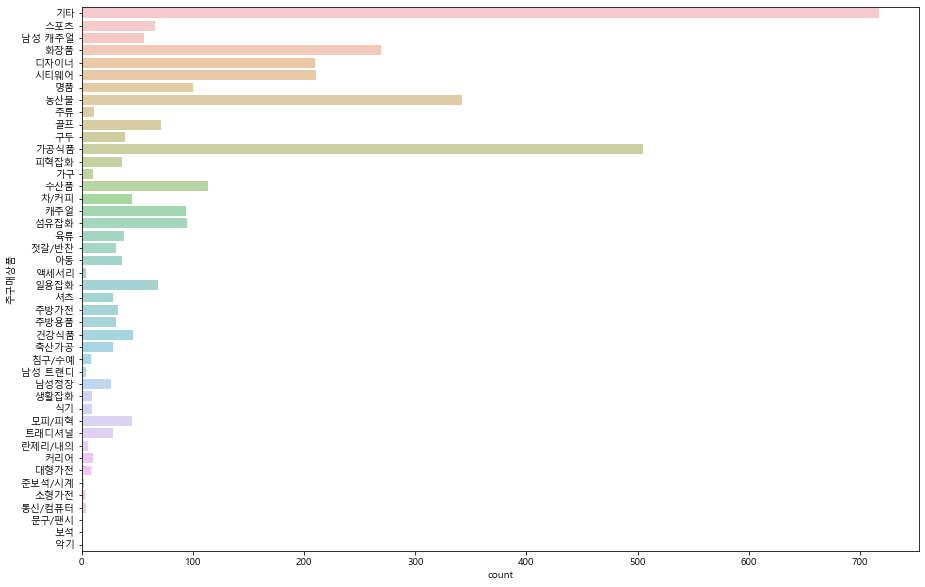

In [20]:
# 범주형 속성 값의 빈도 출력
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(y='주구매상품', data=f, alpha=0.5)

**[파생변수 60]** 주구매 지점

In [21]:
f = data.groupby('cust_id')['store_nm'].agg([
    ('주구매지점', lambda x: x.value_counts().index[0])
]).reset_index()
features.append(f); f

,cust_id,주구매지점
0,0,강남점
1,1,잠실점
2,2,관악점
3,3,광주점
4,4,본 점
...,...,...
3495,3495,본 점
3496,3496,부산본점
3497,3497,창원점
3498,3498,본 점


**[파생변수 61]** 상품별 구매순서

In [22]:
#고객이 매장에 들어와 어떤 상품매장을 순서대로 갔는지에 대해 알기 위해 시간 데이터가 필요한데, 년월일에 대한 데이터만 있어서 구하지 못했습니다.
#일별로 구매한 매장을 묶어서 일별 구매순서를 구하는 건 의미가 없다고 판단했습니다.
#시간별 데이터가 있어서 구매순서를 알 수 있었다면, 고객별로 어떤 매장을 제일 먼저 가는지 파악해서 구매순서를 활용할 수 있다고 생각합니다. 이에 날짜별로 나열된 매장 중 가장 첫 데이터를 처음으로 간 매장으로 간주하고 첫 구매매장을 구했습니다.

first_visit = data.groupby(['cust_id','tran_date'])['gds_grp_mclas_nm'].first().reset_index()
f = first_visit.groupby('cust_id')['gds_grp_mclas_nm'].agg([('주 첫 구매매장', lambda x: x.value_counts().index[0])]).reset_index()
features.append(f)

In [27]:
data = pd.DataFrame({'cust_id': data.cust_id.unique()})
for f in features :
    data = pd.merge(data, f, how='left')
display(data)
data = data.fillna(value=0)
# NA 값이 구매 건수와 금액에서 발생하고 있기 때문에, 0 으로 처리하는 것이 가장 적절하다고 생각합니다.
data.info()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,수산품 구매건수,화장품 구매건수,디자이너 구매건수,시티웨어 구매건수,일용잡화 구매건수,육류 구매건수,차/커피 구매건수,주구매상품,주구매지점,주 첫 구매매장
0,0,68282840,74,922741.0,11264000,35,28,17,19,17,...,4,7,4,7,0,10,0,기타,강남점,화장품
1,1,2136000,3,712000.0,2136000,2,2,2,2,1,...,0,0,0,0,0,0,0,스포츠,잠실점,스포츠
2,2,3197000,4,799250.0,1639000,1,2,2,2,1,...,0,0,0,0,0,0,0,남성 캐주얼,관악점,남성 캐주얼
3,3,16077620,44,365400.0,4935000,24,20,13,18,16,...,5,0,0,0,2,2,2,기타,광주점,수산품
4,4,29050000,3,9683333.0,24000000,2,3,3,2,85,...,0,1,0,0,0,0,0,화장품,본 점,화장품
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600.0,3042900,1,2,2,1,0,...,0,0,0,0,0,0,0,골프,본 점,골프
3496,3496,29628600,13,2279123.0,7200000,9,7,5,8,40,...,0,0,0,7,0,0,0,시티웨어,부산본점,시티웨어
3497,3497,75000,1,75000.0,75000,1,1,1,1,0,...,0,0,0,0,0,0,0,주방용품,창원점,주방용품
3498,3498,1875000,2,937500.0,1000000,1,1,1,2,39,...,0,2,0,0,0,0,0,화장품,본 점,화장품


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3500 entries, 0 to 3499
Data columns (total 62 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cust_id      3500 non-null   int64  
 1   총구매액         3500 non-null   int64  
 2   구매건수         3500 non-null   int64  
 3   평균구매액        3500 non-null   float64
 4   최대구매액        3500 non-null   int64  
 5   구매상품종류1      3500 non-null   int64  
 6   구매상품종류2      3500 non-null   int64  
 7   구매상품종류3      3500 non-null   int64  
 8   내점일수         3500 non-null   int64  
 9   구매주기         3500 non-null   int64  
 10  주말방문비율       3500 non-null   float64
 11  봄-구매비율       3500 non-null   float64
 12  여름-구매비율      3500 non-null   float64
 13  가을-구매비율      3500 non-null   float64
 14  겨울-구매비율      3500 non-null   float64
 15  환불금액         3500 non-null   float64
 16  환불건수         3500 non-null   float64
 17  내점당구매액       3500 non-null   float64
 18  내점당구매건수      3500 non-null   float64
 19  최근3개월_

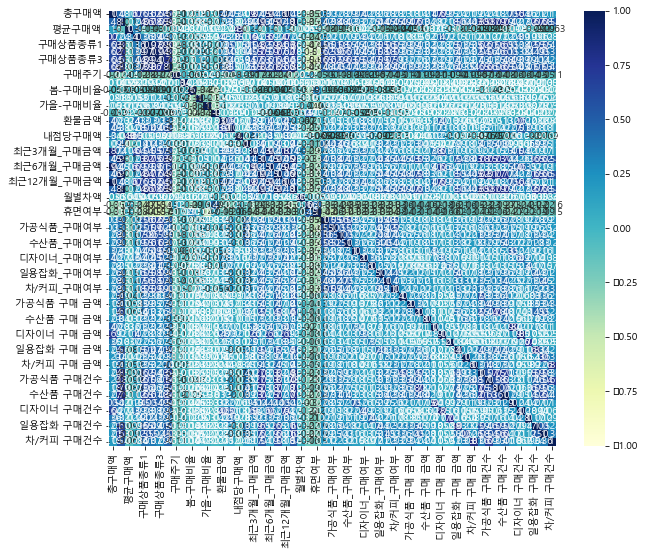

In [28]:
# 상관계수(-1 ~ +1)를 통해 feature 간의 유사성을 파악 
plt.figure(figsize=(10,8))
sns.heatmap(data.iloc[:,1:].corr(), annot=True, cmap="YlGnBu",
            vmin=-1, vmax=1)
plt.show()

# End